# Chapter 3. Deep learning Practice  
 CIFAR-10 Classification with VGG

참고한 사이트: https://github.com/heartcored98/Standalone-DeepLearning/blob/master/




In [21]:
!mkdir results

���� ���͸� �Ǵ� ���� results��(��) �̹� �ֽ��ϴ�.


In [22]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns
import matplotlib.pyplot as plt


In [23]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.exp_name = "exp1_lr"
args.act = 'relu'
args.l2 = 'l2'
args.optim = 'Adam'
args.lr = 0.0015
args.epoch = 50

args.train_batch_size = 512
args.test_batch_size = 1024

print(args)

Namespace(exp_name='exp1_lr', act='relu', l2='l2', optim='Adam', lr=0.0015, epoch=50, train_batch_size=512, test_batch_size=1024)


# Data Preparation

- 기존 CIFAR-10 데이터 저장 코드에서 10을 100으로 바꿔주기만 하면 CIFAR-100 dataset을 사용할 수 있음.   
- train, valid, test set을 각각 전처리하여 partition dictionary에 저장

In [24]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset} # dataset을 나눠놓음


Files already downloaded and verified
Files already downloaded and verified


# Model Architecture

VGG11모델 예시  

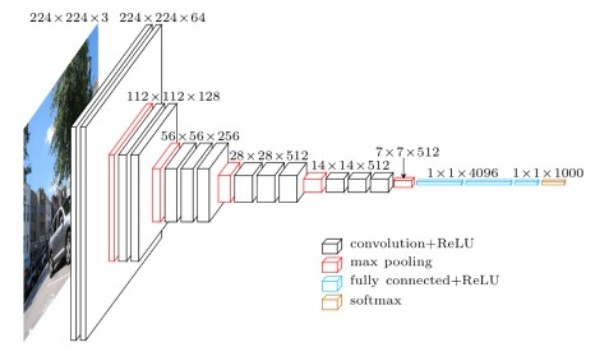

### VGG 모델

In [25]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

In [26]:
class CNN(nn.Module):

    def __init__(self, model_code, in_channels):
        super(CNN, self).__init__()

        self.layers = self._make_layers(model_code, in_channels)
        self.classifier = nn.Sequential(nn.Linear(512, 4096),
                                        nn.ReLU(),
                                        nn.Linear(4096, 10))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, model_code, in_channels):
        layers = nn.ModuleList()
        for x in cfg[model_code]:
            if x != 'M':
                layers.append(nn.Conv2d(in_channels=in_channels,
                                        out_channels=x,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1))
                layers.append(nn.ReLU())
                in_channels = x
            else:
                layers.append(nn.MaxPool2d(kernel_size=2,
                                           stride=2))
        return layers

In [27]:
def dimesion_check(vgg_name):
    model = CNN(vgg_name, 3)
    x = torch.randn(2, 3, 32, 32)
    y = model(x)
    print(y.shape)


In [28]:
vgg_name = 'VGG11'
dimesion_check(vgg_name)

torch.Size([2, 10])


In [29]:
def train(model, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    model.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()

        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return model, train_loss, train_acc

In [30]:
def validate(model, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    model.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [31]:
def test(model, partition, criterion, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    model.eval()

    correct = 0
    total = 0
    te_loss=0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)

            te_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        te_loss = te_loss / len(testloader)
        test_acc = 100 * correct / total
    return te_loss, test_acc


- 실험시 훈련, 검증, 평가를 반복 수행하기 떄문에 사용자 함수화.
- 실험도 여러 조건에서 수행하므로 함수화 진행

- args: 실험변수 저장
- result: 실험변수 저장 dictionary

In [32]:
def experiment(partition,vgg_name, args):

    model = CNN(vgg_name, 3)
    model.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    te_losses = []
    train_accs = []
    val_accs = []
    te_accs = []

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(model, partition, criterion, args)
        te = time.time()
        te_loss, te_acc = test(model,partition,criterion, args)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        te_losses.append(te_loss)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        te_accs.append(te_acc)

        print('Epoch {}, Acc(train/val/test): {:2.2f}/{:2.2f}/{:2.2f}, Loss(train/val/test) {:2.2f}/{:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, te_acc, train_loss, val_loss,te_loss, te-ts))


    result = {}

    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['te_losses'] = te_losses

    result['train_loss'] = train_loss # 마지막 epoch 결과
    result['val_loss'] = val_loss
    result['test_loss'] = te_loss

    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['test_accs'] = te_accs


    result['train_acc'] = train_acc # 마지막 epoch 결과
    result['val_acc'] = val_acc
    result['test_acc'] = te_acc

    return vars(args), result

### Management experiment result


In [33]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result, df_new):
    exp_name = setting['exp_name']

    del df_new['epoch']
    del df_new['test_batch_size']

    filename_df = './results/{}.csv'.format(exp_name)

    df_new.to_csv(filename_df)


def load_exp_result(exp_name):
    dir_path = './results'

    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.csv' in f]

    list_result = []
    for filename in filenames:
        if exp_name in filename:
            df_new = pd.read_csv(join(dir_path, filename))

    return df_new

### Visualization

In [34]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(2, 3)
    fig.set_size_inches(15, 8)

    grouped = df.groupby([var1, var2])
    grouped['train_acc'].mean().plot(kind='bar',  ax=ax[0,0])
    grouped['val_acc'].mean().plot(kind='bar',  ax=ax[0,1])
    grouped['test_acc'].mean().plot(kind='bar',  ax=ax[0,2])
    grouped['train_loss'].mean().plot(kind='bar',  ax=ax[1,0])
    grouped['val_loss'].mean().plot(kind='bar',  ax=ax[1,1])
    grouped['test_loss'].mean().plot(kind='bar',  ax=ax[1,2])

    ax[0,0].set_title('Train Accuracy')
    ax[0,1].set_title('Validation Accuracy')
    ax[0,2].set_title('Test Accuracy')
    plt.tight_layout()
    plt.show()


# Experiment

In [35]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

# ====== Experiment Variable ====== #
name_var1 = 'l2'
name_var2 = 'optim'
list_var1 = [0.0001,0.001]
list_var2 = ['Adam','RMSprop']
df_new = pd.DataFrame()
for var1 in list_var1:
    for var2 in list_var2:
        args.l2 = var2
        args.optim = var1

        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition,vgg_name, args)
        dict_result = result|setting

        df_new = pd.concat([df_new, pd.DataFrame([dict_result])])

save_exp_result(setting, result,df_new) # 실험결과 json으로 저장

Namespace(exp_name='exp1_lr', act='relu', l2=0.0001, optim='Adam', lr=0.0015, epoch=50, train_batch_size=512, test_batch_size=1024)
Epoch 0, Acc(train/val/test): 11.13/9.07/8.54, Loss(train/val/test) 2.30/2.32/2.32. Took 12.19 sec
Epoch 1, Acc(train/val/test): 19.28/23.87/23.73, Loss(train/val/test) 2.00/1.87/1.87. Took 12.00 sec
Epoch 2, Acc(train/val/test): 27.64/30.52/30.23, Loss(train/val/test) 1.81/1.76/1.75. Took 12.20 sec
Epoch 3, Acc(train/val/test): 35.33/39.80/39.92, Loss(train/val/test) 1.66/1.58/1.56. Took 11.78 sec
Epoch 4, Acc(train/val/test): 41.77/46.84/46.52, Loss(train/val/test) 1.52/1.44/1.44. Took 11.73 sec
Epoch 5, Acc(train/val/test): 48.77/49.48/49.96, Loss(train/val/test) 1.37/1.36/1.34. Took 12.34 sec
Epoch 6, Acc(train/val/test): 53.22/54.15/54.01, Loss(train/val/test) 1.27/1.25/1.25. Took 12.17 sec
Epoch 7, Acc(train/val/test): 57.43/55.65/55.39, Loss(train/val/test) 1.17/1.24/1.25. Took 12.17 sec
Epoch 8, Acc(train/val/test): 60.27/59.63/59.09, Loss(train/va

In [37]:
var1 = name_var1
var2 = name_var2
df = load_exp_result('exp1_lr') # 실험결과 불러옴

In [38]:
df.head()

,Unnamed: 0,train_losses,val_losses,te_losses,train_loss,val_loss,test_loss,train_accs,val_accs,test_accs,train_acc,val_acc,test_acc,exp_name,act,l2,optim,lr,train_batch_size
0,0,"[2.29831927335715, 2.0009057431281367, 1.80578...","[2.322308349609375, 1.8739651441574097, 1.7557...","[2.3204334020614623, 1.8671809911727906, 1.752...",0.079445,1.737016,1.802709,"[11.1325, 19.28, 27.6375, 35.3325, 41.77, 48.7...","[9.07, 23.87, 30.52, 39.8, 46.84, 49.48, 54.15...","[8.54, 23.73, 30.23, 39.92, 46.52, 49.96, 54.0...",97.325,70.60,69.77,exp1_lr,relu,0.0001,Adam,0.0015,512
1,0,"[13.957337189324294, 2.303221147271651, 2.3030...","[2.3404793739318848, 2.3035130500793457, 2.304...","[2.3418272495269776, 2.3031774044036863, 2.304...",1.637687,1.590865,1.580618,"[10.0075, 9.705, 9.59, 9.83, 9.8025, 9.8675, 9...","[10.16, 9.89, 10.16, 10.08, 10.16, 10.16, 9.98...","[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....",38.350,39.06,39.99,exp1_lr,relu,0.0001,RMSprop,0.0015,512
2,0,"[2.3036038483245465, 2.302864539472363, 2.3026...","[2.3025779724121094, 2.3026267766952513, 2.302...","[2.302645969390869, 2.3026017904281617, 2.3025...",2.302672,2.302673,2.302603,"[9.8925, 9.7075, 9.7725, 9.9125, 10.0025, 9.72...","[10.29, 9.98, 10.01, 9.69, 10.01, 9.89, 9.69, ...","[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....",9.815,9.69,10.00,exp1_lr,relu,0.0010,Adam,0.0015,512
3,0,"[11.569377500799638, 2.3263052867937692, 2.302...","[2.3026984691619874, 2.3048818826675417, 2.302...","[2.3030338287353516, 2.304623579978943, 2.3026...",2.057474,2.313878,2.303395,"[9.985, 9.995, 10.17, 9.9675, 9.76, 9.89, 9.93...","[10.01, 9.92, 9.92, 10.16, 9.92, 10.01, 9.69, ...","[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....",19.300,12.71,13.09,exp1_lr,relu,0.0010,RMSprop,0.0015,512


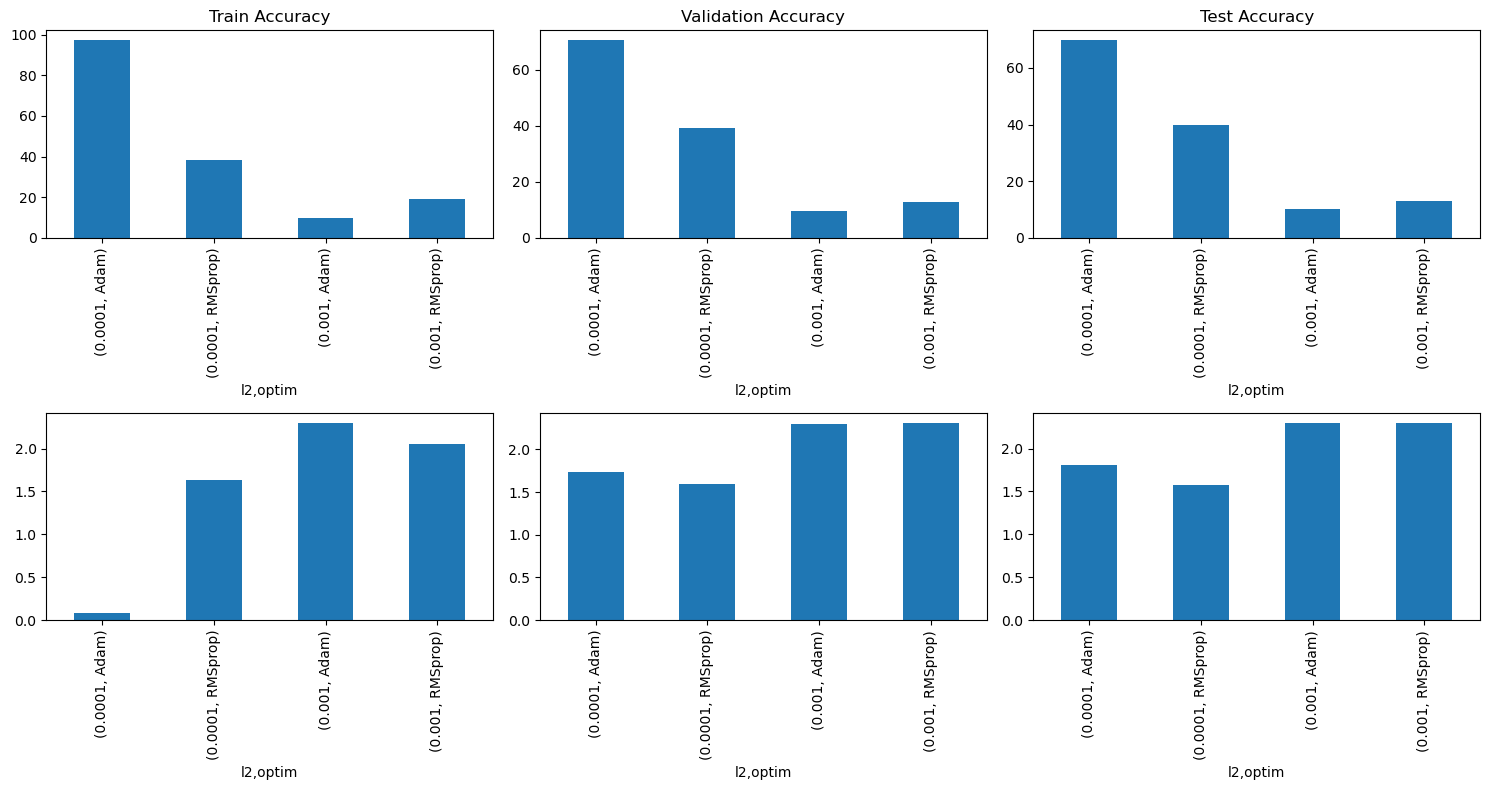

In [39]:
plot_acc(var1, var2, df_new)